# Reading data from  a file


By working with online learning, we expect to obtain data from a stream of data in order to feed our model. However, we typically use saved datasets to develop our basis model before deploying it in a on-line production  environment. So far, the examples we have seen used datasets already contained in the libraries we are studying. These datasets are provided by the library developers, so they fit very well with the shown examples. However,  we will usually need to load our own datasets. River provides different connectors to get data from different  data sources including csv files. River connectors generate iterators over datasets in order to create data streams to feed our online models.

In this example we are going to get data from a csv file to analyze the different problems we can get in this process. We are using the very well-know Titanic dataset downloaded from [Kaggle](https://www.kaggle.com/c/titanic/data). It must be noted that this example is focused only on reading and processing data from a file. The model used and its performance is secondary.

Despite the online learning scenario differs from the batch learning one, we still need to know the input data structure in order to adapt it to our model. We encourage the readers to check the data dictionary from the [Kaggle web page](https://www.kaggle.com/c/titanic/data).


First of all, we load the dataset with Pandas to check data characteristics

In [1]:
import pandas as pd
dataset_path="./datasets/titanic.csv" #you must change this var whether the dataset is in another path
data=pd.read_csv(dataset_path)
print(data.head())
print(data.dtypes)
print(data.describe())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Pa

Despite the fact River already has a connector to iterate from Pandas DataFrame, in this example we are going to use the [one](https://riverml.xyz/0.14.0/api/stream/iter-csv/)  linked to csv files.

<code>iter_csv</code> creates a Python iterator. Each time we use `next` we get a new observation consisting  of a set of both inputs and outputs

In [2]:
from river import stream
from rich import print
titanic = stream.iter_csv(dataset_path)
sample, target = next(titanic)
print(sample)
print(target)

{
    'PassengerId': '1',
    'Survived': '0',
    'Pclass': '3',
    'Name': 'Braund, Mr. Owen Harris',
    'Sex': 'male',
    'Age': '22',
    'SibSp': '1',
    'Parch': '0',
    'Ticket': 'A/5 21171',
    'Fare': '7.25',
    'Cabin': '',
    'Embarked': 'S'
}

None

There is no way to know which sample attributes are targets, so every one is loaded as an input. We must specify the target attribute names

In [3]:
titanic = stream.iter_csv(dataset_path, target="Survived")
sample, target = next(titanic)
print("###Inputs###")
for key, value in sample.items():
    print(f"{key}={value}")
print("###Targets###")
print(f"Survived: {target} - {'yes' if target==1 else 'no'}")

###Inputs###

PassengerId=1

Pclass=3

Name=Braund, Mr. Owen Harris

Sex=male

Age=22

SibSp=1

Parch=0

Ticket=A/5 21171

Fare=7.25

Cabin=

Embarked=S

###Targets###

Survived: 0 - no

## Numerical and categorical (nominal) attributes
Using  a River connector, all the loaded attributes are interpreted as strings by default (categorical attributes). We must use the `converters` parameter to modify this behaviour and assign the specific type to each attribute. We are also able to use  (lambda) functions to *convert* the value of the attributes


* converters (dict) – defaults to None

    All values in the CSV are interpreted as strings by default. You can use this parameter to cast values to the desired type. This should be a dict mapping feature names to callables used to parse their associated values. Note that a callable may be a type, such as float and int.
    
It must be noted that `convert` functions are executed for each iterator call. If some problem occurs during the data conversion of an specific attribute, we will get an exception. Taking into account that data are not loaded at the beginning, but are loaded one by one by the iterator, exceptions are be able to be thrown in any loop moment. An example can be observed using a `float` converter to assign the type of the *Age* attribute. There are some observations without *Age* information, so a ValueError exception will be throw when an empty *Age* value appears.  In this specific example, we used a function (`float_converter`) for dealing with bad type conversions. Moreover, we can use the `drop_nones` parameter to remove the attributes with None values that we inserted during the data type conversion process.


We should also realize that some attributes do not contain valuable information to improve a model. We can drop them when the dataset is loaded or removed in future pipeline steps.


* drop (List[str]) – defaults to None

    Fields to ignore.


In [4]:
removed_attributes=['PassengerId', 'Name', 'Ticket','Fare',]
sex=lambda  g: 0 if g=="male" else 1
def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

cabin=lambda  g: 1 if g!="" else 0 #return 1 if the passenger had a cabin. Otherwise 0
    


titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)



for sample, target in titanic:
    print(sample, 'Survived' if target==1 else 'Deceased')


{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 38.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 54.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 2.0, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 27.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 14.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 4.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 58.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 39.0, 'SibSp': 1, 'Parch': 5, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 14.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 55.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 2.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 31.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 15.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 8.0, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 38.0, 'SibSp': 1, 'Parch': 5, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 19.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 66.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 28.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 42.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 14.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 40.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 27.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 3.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 7.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 49.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 65.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 28.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 5.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 11.0, 'SibSp': 5, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': ''}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 45.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 4.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 17.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 16.0, 'SibSp': 5, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 0.83, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 33.0, 'SibSp': 3, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 1, 'Parch': 3, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 23.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 46.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 59.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 71.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 34.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 37.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 14.5, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 20.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 70.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 2.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 21.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 32.5, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 32.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 54.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 12.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 47.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 19.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 37.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 24.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 19.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 9.0, 'SibSp': 2, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 36.5, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 22.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 55.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 40.5, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 44.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 1.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 9.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 45.0, 'SibSp': 1, 'Parch': 4, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 61.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 4.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 1.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 56.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 50.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 9.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 1.0, 'SibSp': 2, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 4.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 40.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 19.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 3.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 44.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 58.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 45.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 2.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 31.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 42.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 38.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 20.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 59.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 5.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 44.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 8.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 44.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 1, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 37.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 54.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 29.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 62.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 41.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 29.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 50.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 3.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 52.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 58.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 41.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 37.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 63.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 7.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 35.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 65.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 19.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 23.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 2.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 50.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 0.92, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 17.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 30.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 18.0, 'SibSp': 2, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 26.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 43.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 54.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 31.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 40.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 22.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 61.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 31.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 16.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 45.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 38.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 41.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 2.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 24.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 3.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 15.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 40.0, 'SibSp': 1, 'Parch': 4, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 45.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 60.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 3.0, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 1.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 1.0, 'SibSp': 5, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 23.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 46.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 21.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 3.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 33.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'Q'}
Survived

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 44.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 34.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 10.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 28.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 28.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 42.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 50.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 14.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 21.0, 'SibSp': 2, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 2, 'Parch': 3, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 64.0, 'SibSp': 1, 'Parch': 4, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 45.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 4.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 13.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 5.0, 'SibSp': 2, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 52.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 36.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 49.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 65.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 50.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 48.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 48.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 56.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 0.75, 'SibSp': 2, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 33.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 2.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 9.0, 'SibSp': 5, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 50.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 63.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 58.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 9.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 55.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 71.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 54.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 25.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 37.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 18.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 33.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 54.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 36.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 44.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 40.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 50.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 2, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 2.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 7.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 36.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 9.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 11.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 32.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 50.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 64.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 19.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 8.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 17.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 62.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 48.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 39.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 36.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 29.0, 'SibSp': 0, 'Parch': 4, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 62.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 53.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 39.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 25.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 39.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 54.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 60.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 52.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 37.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 36.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 49.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 49.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 2, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 44.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 36.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 22.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 39.0, 'SibSp': 1, 'Parch': 5, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 34.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 26.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 4.0, 'SibSp': 2, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 27.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 42.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 61.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 57.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 80.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 9.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 31.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 41.0, 'SibSp': 0, 'Parch': 5, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 2.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 0.75, 'SibSp': 2, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 48.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 56.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 24.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 32.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 58.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 50.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 32.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 43.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 40.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 31.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 70.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 24.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 43.0, 'SibSp': 1, 'Parch': 6, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 14.0, 'SibSp': 5, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 60.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 14.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 15.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 31.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 4.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 60.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 52.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 44.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 49.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 18.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 48.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 52.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 6.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 50.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 27.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 30.0, 'SibSp': 3, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 11.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 28.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 48.0, 'SibSp': 1, 'Parch': 3, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 21.0, 'SibSp': 2, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 70.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 19.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 4.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 6.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 48.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 0.67, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 41.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 36.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 51.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 30.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 48.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 57.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 54.0, 'SibSp': 1, 'Parch': 3, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 5.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 43.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 13.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 17.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 8.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 1.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 46.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 49.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 30.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 31.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 11.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 0.42, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 33.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 6.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 30.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 31.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 43.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 10.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 52.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 27.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 2.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 1.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 62.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': ''}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 15.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 0, 'Age': 0.83, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 39.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 34.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 4.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 74.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 9.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 16.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 44.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 1, 'Age': 45.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 3, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 41.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 21.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 48.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 27.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 4.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 47.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 1, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 1, 'Age': 28.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 1, 'Age': 15.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 56.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 2, 'Sex': 1, 'Age': 25.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 3, 'Sex': 1, 'Age': 39.0, 'SibSp': 0, 'Parch': 5, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

{'Pclass': 2, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 1, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Survived

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Deceased

{'Pclass': 1, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Survived

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Deceased

### One hot encoding

Different models can be used to deal with the same type of ML problem. However, not all the models can deal with categorical attributes. A typical solution is the one-hot attribute encoding. Rivers provides a preprocessing function to online encode categorical attributes. It must be highlighted that this method does not need to know all the categories in advance. They are added on the fly.

Let's check this one-hot encoding funcion with the *Embarked* attribute

In [5]:
from river import stream, compose, preprocessing
titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)



pp = compose.Select('Embarked') | preprocessing.OneHotEncoder(sparse=False)
for sample, target in titanic:
    pp = pp.learn_one(sample)
    print(pp.transform_one(sample))
    

{'Embarked_S': 1}

{'Embarked_S': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

#### Adding preprocessing operations to the pipeline
We can create a River pipeline with different preprocessing operations for preparing the observations for developing the model. We are able to include feature engineering, one-hot encoding, feature removing, etc.

In [6]:
from river import stream, compose, preprocessing
removed_attributes=['PassengerId', 'Name', 'Ticket','Fare',]
sex=lambda  g: 0 if g=="male" else 1
def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

cabin=lambda  g: 1 if g!="" else 0 #return 1 if the passenger had a cabin. Otherwise 0

def generate_new_attributes(x):#feature enginnering
    x["FirstClass"]=1 if x["Pclass"]==1 else 0
    x["FamilyMembers"]=x["SibSp"]+x["Parch"]+1
    return x

titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)

to_discard=['SibSp','Parch','Embarked',"FirstClass"]#feature removing

pp=compose.FuncTransformer(generate_new_attributes)\
            +(compose.Select('Embarked') | preprocessing.OneHotEncoder(sparse=False))\
            |compose.Discard(*to_discard)
                            
    

for sample, target in titanic:
    pp = pp.learn_one(sample)
    print(pp.transform_one(sample), 'Survived' if target==1 else 'Deceased')
    

{'Embarked_S': 1, 'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'Cabin': 0, 'FamilyMembers': 2}
Deceased

{'Embarked_S': 0, 'Embarked_C': 1, 'Pclass': 1, 'Sex': 1, 'Age': 38.0, 'Cabin': 1, 'FamilyMembers': 2}
Survived

{'Embarked_S': 1, 'Embarked_C': 0, 'Pclass': 3, 'Sex': 1, 'Age': 26.0, 'Cabin': 0, 'FamilyMembers': 1}
Survived

{'Embarked_S': 1, 'Embarked_C': 0, 'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'Cabin': 1, 'FamilyMembers': 2}
Survived

{'Embarked_S': 1, 'Embarked_C': 0, 'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'Cabin': 0, 'FamilyMembers': 1}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Pclass': 3, 'Sex': 0, 'Cabin': 0, 'FamilyMembers': 1}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 54.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 2.0,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 1,
    'Age': 14.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 4.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 58.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 14.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 55.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 2.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Pclass': 2, 'Sex': 0, 'Cabin': 0, 'FamilyMembers': 1}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Pclass': 3, 'Sex': 1, 'Cabin': 0, 'FamilyMembers': 1}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 15.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 8.0,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 38.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Survived

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Pclass': 3, 'Sex': 0, 'Cabin': 0, 'FamilyMembers': 1}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 1,
    'FamilyMembers': 6
}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Pclass': 3, 'Sex': 1, 'Cabin': 0, 'FamilyMembers': 1}
Survived

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Pclass': 3, 'Sex': 0, 'Cabin': 0, 'FamilyMembers': 1}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Pclass': 1, 'Sex': 1, 'Cabin': 1, 'FamilyMembers': 2}
Survived

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Pclass': 3, 'Sex': 1, 'Cabin': 0, 'FamilyMembers': 1}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 66.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Pclass': 3, 'Sex': 0, 'Cabin': 0, 'FamilyMembers': 1}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 14.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Pclass': 3, 'Sex': 0, 'Cabin': 0, 'FamilyMembers': 1}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 1,
    'Age': 3.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Pclass': 3, 'Sex': 0, 'Cabin': 0, 'FamilyMembers': 1}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Pclass': 3, 'Sex': 0, 'Cabin': 0, 'FamilyMembers': 2}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Pclass': 3, 'Sex': 1, 'Cabin': 0, 'FamilyMembers': 1}
Survived

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Pclass': 3, 'Sex': 0, 'Cabin': 0, 'FamilyMembers': 3}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 7.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 49.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 65.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Pclass': 1, 'Sex': 0, 'Cabin': 1, 'FamilyMembers': 1}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 5.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 11.0,
    'Cabin': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 38.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 4.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 0.83,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 23.0,
    'Cabin': 1,
    'FamilyMembers': 6
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 46.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 59.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 71.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 37.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 14.5,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 70.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 0,
    'Age': 32.5,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 32.5,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 54.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 12.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 47.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 37.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 9.0,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 36.5,
    'Cabin': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 55.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 40.5,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 1.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 9.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 61.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 4.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 1.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 56.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 50.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 9.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 1.0,
    'Cabin': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 4.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 3.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 44.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 58.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 45.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 32.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 59.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 5.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 8.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 37.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 54.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 62.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 41.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 50.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 3.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 52.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 58.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 41.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 37.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 63.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 7.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 65.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 23.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 1,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 50.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 0.92,
    'Cabin': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 1,
    'FamilyMembers': 5
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 43.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 54.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 61.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 45.5,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 41.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 2.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FamilyMembers': 6
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 3.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 15.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 38.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 60.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 3.0,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 42.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 1.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 1.0,
    'Cabin': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 23.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 46.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 3.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 10.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 42.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 50.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 14.0,
    'Cabin': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 64.0,
    'Cabin': 1,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 4.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 13.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 5.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 52.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 49.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 65.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 50.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 48.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 48.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 56.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 0.75,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 1,
    'Age': 23.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 9.0,
    'Cabin': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 50.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 63.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 58.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 9.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 55.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 71.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 54.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 25.0,
    'Cabin': 1,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 37.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 54.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 34.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 44.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 40.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 50.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 7.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 9.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 11.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 50.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 64.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 8.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 62.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 48.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 62.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 53.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 54.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 60.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 52.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 37.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 49.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 49.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 4.0,
    'Cabin': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 61.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 57.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 80.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 9.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 41.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 0.75,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 48.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 56.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 58.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 50.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 43.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 70.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 24.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 43.0,
    'Cabin': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 14.0,
    'Cabin': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 60.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 14.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 15.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 4.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 60.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 52.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 49.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 48.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 52.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 38.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 6.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 50.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 11.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 48.0,
    'Cabin': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 1,
    'FamilyMembers': 5
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 70.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 4.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 6.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 48.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 0.67,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 41.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 51.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 30.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 48.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 57.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 54.0,
    'Cabin': 0,
    'FamilyMembers': 5
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 5.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 43.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 13.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 8.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 1.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 46.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 49.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 11.0,
    'Cabin': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 0.42,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 6.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 30.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 43.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 10.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 52.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 2.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 0,
    'Age': 1.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 62.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 15.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 0.83,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 34.5,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 4.0,
    'Cabin': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 74.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 9.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 44.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 41.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 48.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 42.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 4.0,
    'Cabin': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 47.0,
    'Cabin': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 2,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 3,
    'Sex': 1,
    'Age': 15.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 1,
    'Age': 56.0,
    'Cabin': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 1,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 2,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 1,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 1,
    'Cabin': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Pclass': 1,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Pclass': 3,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FamilyMembers': 1
}
Deceased

#### Wrapping up
Finally, we are able to include every step in a pipeline with a model as we shown in previous examples. Just remember that this example is focused on reading and processing data from a file. The model used and its performance is secondary.

Accuracy: 72.92%

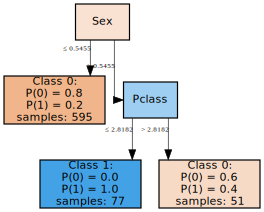

In [7]:
from river import stream, compose, preprocessing, evaluate, metrics
from river.tree import HoeffdingTreeClassifier
removed_attributes=['PassengerId', 'Name', 'Ticket','Fare',]
sex=lambda  g: 0 if g=="male" else 1
def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

cabin=lambda  g: 1 if g!="" else 0 #return 1 if the passenger had a cabin. Otherwise 0

def generate_new_attributes(x):#feature enginnering
    x["FirstClass"]=1 if x["Pclass"]==1 else 0
    x["FamilyMembers"]=x["SibSp"]+x["Parch"]+1
    return x

titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)

to_discard=['SibSp','Parch','Embarked',"FirstClass"]#feature removing

model=compose.FuncTransformer(generate_new_attributes)\
            +(compose.Select('Embarked') | preprocessing.OneHotEncoder(sparse=False))\
            |compose.Discard(*to_discard)

model|= HoeffdingTreeClassifier(grace_period=50)


print(evaluate.progressive_val_score(dataset=titanic, model=model, metric=metrics.Accuracy()))
model['HoeffdingTreeClassifier'].draw()
                            

# Concept Drift

As you have seen so far, stream learning needs models that can adapt over time and be trained in the progressive validation schema. The main reason for this requirement is the fact that it is assumed that data can change over time. Classical machine learning models assume that data has a probability distribution, which is usually fixed, i.e., stationary. However, stream learning has to deal with data whose distribution can change, which drives a new phenomenon called **Concept drift**.

Concept drifts can be classified into two main groups, virtual and real. In the first one, virtual concept drift, the distribution of the features changes whereas the relationship between features and target remains stable. Consequently, we would see changes in $P(X)$ but the joint distribution $P(X,y)$ remain, being $X$ the feature set and $y$ the desired output. On the other hand, in real concept drift, this joint probability is one that varies. It is worth mentioning that this change can be abrupt or gradual.

There are many situations where a concept drift can happen, such as the stock market, the electric demand, or the movie preference of a user, ... Take for a moment the example of a supermarket that has to restock its supplies, could you imagine the disaster that would have been to use nowadays a recommendation model trained with the data from the beginning of 2020 pandemia where people only want face mask, hydroalcoholic gel and toilet paper. So, over time the preferences of users change and the systems should adapt to this point.

The most common approach to deal with the concept drift is the use of drift-aware methods to trigger mitigation mechanisms. The main objective of the latter is to rise an alarm when a change in performance is detected. Some authors establish some desirable properties for the detectors, such as maximising the number of True Positives (TP) while it keeps the (FP) to a minimum, i.e., with high precision. Additionally, the other feature of these alarm methods is to be efficient and, theoretically, able to work with an infinite data stream.

Let's see an example composed by 5 distributions of 5,000 samples with the following properties:
* $dist_a:\mu=0.9, \sigma=0.01$
* $dist_b:\mu=0.8, \sigma=0.05$
* $dist_c:\mu=0.4, \sigma=0.02$
* $dist_d:\mu=0.6, \sigma=0.1$
* $dist_e:\mu=0.6, \sigma=0.01$

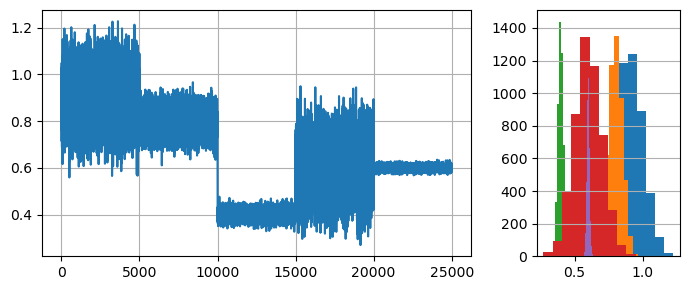

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Generate data for 5 distributions
random_state = np.random.RandomState(seed=41)
dist_a = random_state.normal(0.9, 0.1, 5000)
dist_b = random_state.normal(0.8, 0.05, 5000)
dist_c = random_state.normal(0.4, 0.02, 5000)
dist_d = random_state.normal(0.6, 0.1, 5000)
dist_e = random_state.normal(0.6, 0.01, 5000)

# Create out synthetic data stream
stream = np.concatenate((dist_a, dist_b, dist_c, dist_d, dist_e))

# Auxiliary function to analyse the data
def plot_data(stream, dists, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    for id, dist in enumerate(dists):
        ax2.hist(dist, label=f'dist_{id}')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

plot_data(stream, [dist_a, dist_b, dist_c, dist_d, dist_e])

Now, let's see an example of one of these detectors, which is called Adaptative WINdowing (ADWIN). This method has as objective to determine when a change in the properties of the data stream happens. The idea is to tackle the deviation as soon as possible.


Change detected at index 5471

Change detected at index 10047

Change detected at index 15071

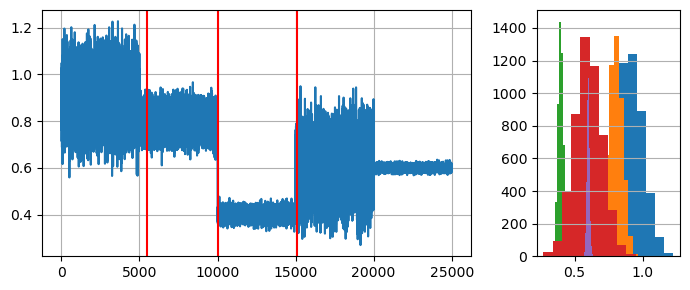

In [9]:
from river import drift

drift_detector = drift.ADWIN()
drifts = []

for i, val in enumerate(stream):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)

plot_data(stream, [dist_a, dist_b, dist_c, dist_d, dist_e], drifts)

As we can see, this method has  identified 3 out of 4 drifts. Another point to highlight, if the change is gradual, such as the first drift, it would require more steps to identity that change. In this particular case, it takes a solid amount to detect instead of 5000 o close, it will require nearly 500 samples to b aware of the change

But, why the method has not raised an alarm in the last change? Because it is not a drift, you should remember that a drift is a change in the relationship between data and target and, in this case, there is no such because the average is the same. Here arise another of the key point of these detectors, they can only be used for univariate data. That is the reason why they are used to monitor a model's performance and not the data itself.